# Entropy and feature importance

The Jensen-Shannon (JS) divergence is a measure of similarity between two probability distributions. It is a symmetric and finite measure that addresses some limitations of the Kullback-Leibler (KL) divergence, such as its asymmetry and potential to be infinite. Here’s a breakdown of how to interpret the JS divergence:

The JS divergence ranges from 0 to 1 when using the base-2 logarithm. A value of 0 indicates that the two distributions are identical, while higher values indicate greater dissimilarity. Unlike the KL divergence, the JS divergence is symmetric: $JS(p || q) = JS(q || p)$.


- **JS Divergence = 0**: The two distributions are identical.
- **JS Divergence > 0 and close to 0**: The two distributions are very similar.
- **JS Divergence < 1 but far from 0**: The distributions have some significant differences.
- **JS Divergence = 1**: The two distributions are completely dissimilar in the regions where they have positive probability mass.


Suppose we have two distributions, \( P \) and \( Q \), representing the feature importance distribution comparing with equal weights feature importance.

- If the JS divergence is 0, the distributions are identical, indicating that features have the same importance

- If the JS divergence is close to 0, the distributions are very similar, suggesting that the features have similar importance

- If the JS divergence is far from 0, the distributions have significant differences, implying that the features have different importance

KL Divergence: 0.8725590420520595
Jensen-Shannon Divergence: 0.5908490495385915
Entropy Ratio: 0.8315927555355627


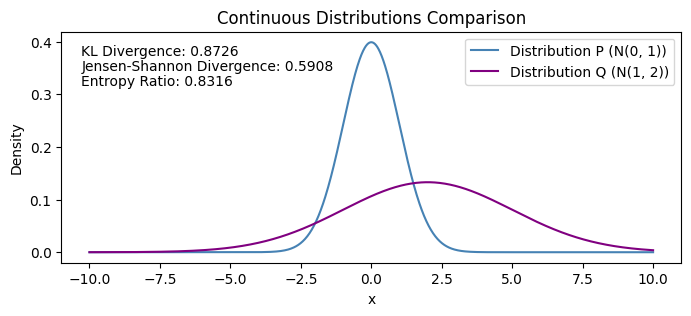

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy, norm
from scipy.spatial.distance import jensenshannon

def jensen_shannon_divergence(p, q):
    """Calculate Jensen-Shannon divergence between two distributions."""
    return jensenshannon(p, q, base=2)

def entropy_ratio(p, q):
    """Calculate the ratio of entropies of two distributions."""
    return entropy(p) / entropy(q)

x = np.linspace(-10, 10, 1000)
p = norm.pdf(x, loc=0, scale=1)
q = norm.pdf(x, loc=2, scale=3)

kl_div = entropy(p, q)
js_div = jensen_shannon_divergence(p, q)
entropy_rat = entropy_ratio(p, q)

print(f"KL Divergence: {kl_div}")
print(f"Jensen-Shannon Divergence: {js_div}")
print(f"Entropy Ratio: {entropy_rat}")

plt.figure(figsize=(8, 3)) 
plt.plot(x, p, label='Distribution P (N(0, 1))', color='steelblue')
plt.plot(x, q, label='Distribution Q (N(1, 2))', color='purple')

plt.xlabel('x')
plt.ylabel('Density')
plt.title('Continuous Distributions Comparison')
plt.legend()

plt.figtext(0.15, 0.80, f"KL Divergence: {kl_div:.4f}", fontsize=10)
plt.figtext(0.15, 0.75, f"Jensen-Shannon Divergence: {js_div:.4f}", fontsize=10)
plt.figtext(0.15, 0.70, f"Entropy Ratio: {entropy_rat:.4f}", fontsize=10)

plt.show()

In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from holisticai.datasets import load_dataset

dataset = load_dataset('us_crime')
dataset = dataset.train_test_split(test_size=0.2, random_state=42)
train = dataset['train'].sample(300)
test = dataset['test'].sample(50)

model = LinearRegression()
model.fit(train['X'], train['y'])

from holisticai.explainability.metrics import regression_explainability_features
xai_features_permutation = regression_explainability_features(test['X'], test['y'], model.predict, strategy="permutation")
xai_features_surrogate = regression_explainability_features(test['X'], test['y'], model.predict, strategy="surrogate")

from holisticai.explainability.commons import LIMEImportanceCalculator
feature_importance_fn = LIMEImportanceCalculator("regression", train['X'], model)
xai_features_lime = regression_explainability_features(test['X'], test['y'], model.predict, strategy=feature_importance_fn)

from holisticai.explainability.commons import SHAPImportanceCalculator
feature_importance_fn = SHAPImportanceCalculator(train['X'], model)
xai_features_shap = regression_explainability_features(test['X'], test['y'], model.predict, strategy=feature_importance_fn)

In [60]:
import numpy as np

class ImportanceSpread:
    def __call__(self, feature_importance):
        """
        Parameters
        ----------
        feature_importance: np.array
            array with raw feature importance
        divergence: bool
            if True calculate divergence instead of ratio
        """
        tol = 1e-8
        feature_importances = np.array(feature_importance.feature_importances.values[:, 1], dtype=float)
        if len(feature_importances) == 0 or sum(feature_importances) < tol:
            return 0 if self.divergence else 1

        importance = feature_importances
        from scipy.stats import entropy
        from scipy.spatial.distance import jensenshannon

        feature_weight = importance / sum(importance)
        feature_equal_weight = np.array([1.0 / len(importance)] * len(importance))
        
        kl_div = entropy(feature_weight, feature_equal_weight)
        js_div = jensenshannon(feature_weight, feature_equal_weight, base=2)
        entropy_rat = entropy(feature_weight) / entropy(feature_equal_weight)
        
        print(f'KL Divergence: {kl_div}')
        print(f'JS Divergence: {js_div}')
        print(f'Entropy Ratio: {entropy_rat}')

        import matplotlib.pyplot as plt
        plt.figure(figsize=(8, 3)) 
        plt.plot(feature_weight, label='Feature Weight')
        plt.plot(feature_equal_weight, label='Equal Weight')
        
        plt.xlabel('Feature Index')
        plt.ylabel('weight')
        plt.title('Feature Weight vs Equal Weight')
        plt.legend()
        
        #if self.divergence is False:
        #    return jensenshannon(feature_weight, feature_equal_weight)
        #else:  # noqa: RET505
        #    return entropy(feature_weight, feature_equal_weight)  # divergence

class SpreadRatio(ImportanceSpread):
    name: str = "Spread Ratio"
    reference = 0
    divergence = False


def spread_ratio(feature_importance):
    metric = SpreadRatio()
    return metric(feature_importance)


KL Divergence: 1.8714393353985923
JS Divergence: 0.7315251439960732
Entropy Ratio: 0.5944982739736839


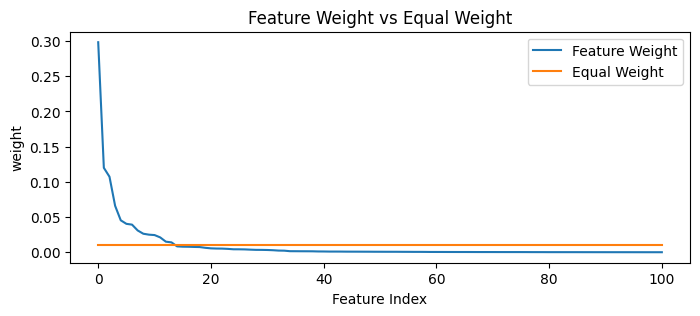

In [61]:
spread_ratio(xai_features_permutation.feature_importance)

KL Divergence: 3.4911270093113367
JS Divergence: 0.9289625917947809
Entropy Ratio: 0.2435458626547894


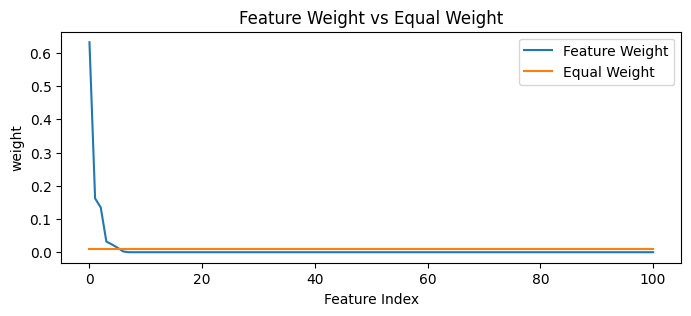

In [62]:
spread_ratio(xai_features_surrogate.feature_importance)

KL Divergence: 0.028204972015076143
JS Divergence: 0.10051791123988052
Entropy Ratio: 0.9938885730259577


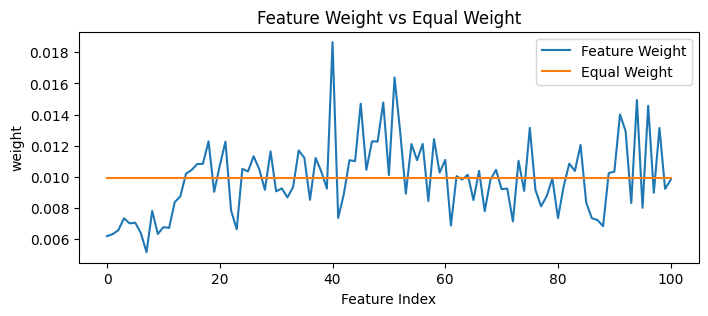

In [63]:
spread_ratio(xai_features_lime.feature_importance)

KL Divergence: 0.7694006980177285
JS Divergence: 0.5073538480398341
Entropy Ratio: 0.8332869758850125


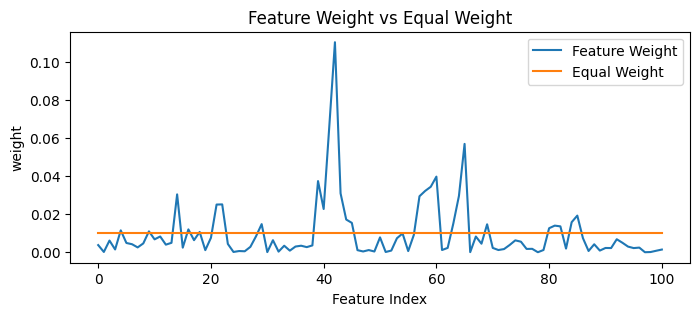

In [64]:
spread_ratio(xai_features_shap.feature_importance)